<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/05_mnist_nice_son.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.datasets import make_moons

In [35]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset.data[idx]
        y = self.dataset.targets[idx]
        return x, y

In [36]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2), nn.ReLU()) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(input_dim), requires_grad=True)


    def forward(self, x):
        x = x[0].to(torch.float32)
        x = x.view(len(x), -1,) / 255
        return self.f(x)

    def coupling_layer(self, x, m, flow, forward=True):

        x_a = x[:, : x.shape[1]//2] if flow%2==0 else x[:, x.shape[1]//2 :]
        x_b = x[:, x.shape[1]//2 :] if flow%2==0 else x[:, : x.shape[1]//2]

        if forward:
            y_b = (x_b - m(x_a))
        else:
            y_b = (x_b + m(x_a))

        z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)

        return z


    def f(self, x):
        z = x

        for flow, model in enumerate(self.m, start=1):
            z = self.coupling_layer(z, model, flow, forward=True)

        z = z * torch.exp(-self.s)
        log_det_j = torch.sum(-self.s)

        return z, log_det_j

    def f_inv(self, z):
        x = z * torch.exp(self.s)

        for flow, model in reversed(list(enumerate(self.m, start=1))):
            x = self.coupling_layer(x, model, flow,forward=False)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) + log_det_j).mean()
        return loss

In [37]:
train_image = torchvision.datasets.MNIST(root='dataset', train=True, download=True, transform=transforms.ToTensor())
test_image = torchvision.datasets.MNIST(root='dataset', train=False, download=True, transform=transforms.ToTensor())



train_data = Data(train_image)
test_data = Data(test_image)

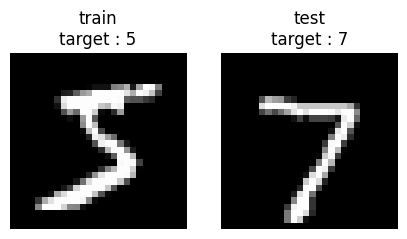

In [38]:
image_train, category_train = train_data[0]
image_test, category_test = test_data[0]


plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((28,28)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((28,28)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [39]:
data_dim = 28*28
prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))

model = NICE(input_dim=data_dim, hidden_layer=128, num_flows=20)

train_loader = DataLoader(train_data, batch_size=20000)


In [40]:
epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%1 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  341.32787068684894
Epoch :  2   -----------> Loss :  313.8085428873698
Epoch :  3   -----------> Loss :  289.4921875
Epoch :  4   -----------> Loss :  265.24317423502606
Epoch :  5   -----------> Loss :  240.96836853027344
Epoch :  6   -----------> Loss :  216.77385457356772
Epoch :  7   -----------> Loss :  192.6920369466146
Epoch :  8   -----------> Loss :  168.57988993326822
Epoch :  9   -----------> Loss :  144.57770284016928
Epoch :  10   -----------> Loss :  120.6489766438802
Epoch :  11   -----------> Loss :  96.78119659423828
Epoch :  12   -----------> Loss :  72.97783660888672
Epoch :  13   -----------> Loss :  49.22779846191406
Epoch :  14   -----------> Loss :  25.52720769246419
Epoch :  15   -----------> Loss :  1.836934010187785
Epoch :  16   -----------> Loss :  -21.748108863830566
Epoch :  17   -----------> Loss :  -45.36462275187174
Epoch :  18   -----------> Loss :  -68.9583740234375
Epoch :  19   -----------> Loss :  -92.5365880330403

In [41]:
test = prior.sample((50,))
test

tensor([[-1.3065, -0.3427, -0.0239,  ...,  0.1802,  0.3870,  0.4966],
        [-0.8859,  0.8159,  0.9804,  ...,  1.0856, -0.5229, -0.1595],
        [ 0.3062,  0.7999,  0.5130,  ...,  1.1399,  1.0202, -0.0801],
        ...,
        [ 1.9391,  0.4756, -1.5728,  ...,  0.6543, -0.4709,  0.8078],
        [ 0.7112,  1.3784,  0.4378,  ..., -0.5080, -1.2805, -1.4083],
        [-0.3732,  0.5342,  2.0975,  ..., -0.1333, -0.3126, -0.1643]])

In [42]:
sonuc = model.f_inv(test)


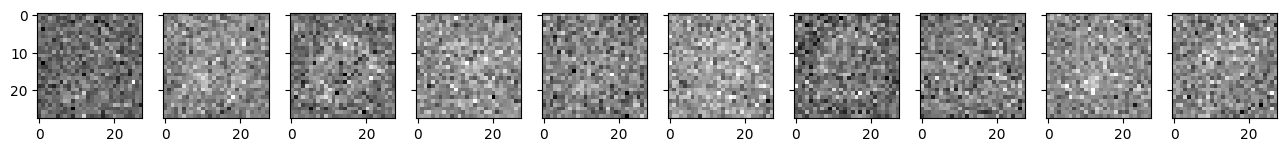

In [46]:
test = prior.sample((10,))
sonuc = model.f_inv(test)

fig, axs = plt.subplots(1, 10, sharex=True, sharey=True, figsize=(16, 8))

for i in range(0,10):

    axs[i].imshow(sonuc[i].detach().numpy().reshape((28,28)), cmap='gray')
    #axs[i].axis('off')

fig.show()